### Setup

In [1]:
import pandas as pd
import numpy as np
from pybiomart import Server
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge

### Load Embeddings and HPO annotations

In [2]:
# Load Embeddings (X)
# index = ensemble ID
X_log = pd.read_csv('data/omics_embedding/OMICS_EMB_log_sigma.tsv', sep="\t" ,index_col=0) 
X_org = pd.read_csv('data/omics_embedding/OMICS_EMB.tsv', sep="\t" ,index_col=0)

# Load HPO Annotations (Raw Data)

phenotype = pd.read_csv('data/hpo/phenotype.hpoa', sep='\t', comment='#', header=None, 
                     names=['gene_id', 'gene_symbol', 'hpo_name', 'hpo_id', 'freq', 'disease', 'etc'])

hpo_df = pd.read_csv('data/hpo/genes_to_phenotype.txt', sep='\t', comment='#')

/var/folders/3b/dy6ckr3151511vk8dm2043gh0000gn/T/ipykernel_86013/2785294945.py:8: DtypeWarning: Columns (2,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  phenotype = pd.read_csv('data/hpo/phenotype.hpoa', sep='\t', comment='#', header=None,


Ensemble ID <-> NCBI mapping

In [3]:
# get ensembl to ncbi mapping

server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']


print("Querying BioMart...")
mapping_df = dataset.query(attributes=['ensembl_gene_id', 'entrezgene_id'])


print("Columns returned by BioMart:", mapping_df.columns.tolist())


mapping_df.rename(columns={
    'Gene stable ID': 'ensembl_id', 
    'NCBI gene (formerly Entrezgene) ID': 'ncbi_id'
}, inplace=True)


mapping_df = mapping_df.dropna(subset=['ncbi_id'])

mapping_df['ncbi_id'] = mapping_df['ncbi_id'].astype(int).astype(str)

print(mapping_df.head())

Querying BioMart...
Columns returned by BioMart: ['Gene stable ID', 'NCBI gene (formerly Entrezgene) ID']
         ensembl_id    ncbi_id
5   ENSG00000198888       4535
9   ENSG00000198763       4536
15  ENSG00000198804       4512
16  ENSG00000210151  113219467
18  ENSG00000198712       4513


In [4]:
hpo_df['ncbi_gene_id'] = hpo_df['ncbi_gene_id'].astype(str)

# attach Ensembl IDs to HPO data
hpo_mapped = hpo_df.merge(mapping_df, left_on='ncbi_gene_id', right_on='ncbi_id', how='inner')

print(f"Original annotations: {len(hpo_df)}")
print(f"Mapped annotations:   {len(hpo_mapped)}")

Original annotations: 320212
Mapped annotations:   352989


In [5]:
# how many unique Ensembl IDs are associated with each HPO ID
term_counts = hpo_mapped.groupby('hpo_id')['ensembl_id'].nunique()

# at least 20 genes annotated (like in paper)
min_genes = 20
valid_terms = term_counts[term_counts >= min_genes].index


hpo_filtered = hpo_mapped[hpo_mapped['hpo_id'].isin(valid_terms)]

print(f"Filtering criteria: >= {min_genes} genes per term")
print(f"Number of HPO terms remaining: {len(valid_terms)}")


# rows = ensembl IDs, columns = HPO IDs
Y_full = pd.crosstab(hpo_filtered['ensembl_id'], hpo_filtered['hpo_id'])

Y_full = (Y_full > 0).astype(int)

print(f"Y Matrix Shape: {Y_full.shape} (Genes x {Y_full.shape[1]} HPO Terms)")

Filtering criteria: >= 20 genes per term
Number of HPO terms remaining: 2531
Y Matrix Shape: (5752, 2531) (Genes x 2531 HPO Terms)


In [6]:
# find genes present in both datasets
common_genes = X_log.index.intersection(Y_full.index)

X_aligned = X_log.loc[common_genes]
Y_aligned = Y_full.loc[common_genes]

print(f"Final Training Data (transformed): {len(common_genes)} genes")

# original embeddings
common_genes_org = X_org.index.intersection(Y_full.index)


X_aligned_org = X_org.loc[common_genes_org]
Y_aligned = Y_full.loc[common_genes_org]

print(f"Final Training Data (original): {len(common_genes_org)} genes")

Final Training Data (transformed): 5079 genes
Final Training Data (original): 5079 genes


In [7]:
# Save the index (Ensembl IDs) to a simple text file
X_aligned.index.to_series().to_csv("common_genes.csv", index=False, header=False)

### Ridge Regression

In simple terms, Ridge Regression is Linear Regression with a penalty.

- The Core Idea: Like standard regression, it tries to find a linear equation (a weighted sum of your omics features) that best predicts the target (whether a gene has a specific HPO term).

- The Problem it Solves: Biological data (like gene expression) is often "multicollinear"—meaning many features are correlated (e.g., if Gene A is expressed, Gene B is often expressed too). Standard regression fails or overfits badly on this.

- The "Ridge" Solution: It adds a "penalty" (L2 regularization) to the loss function that shrinks the coefficients of the model towards zero. This prevents any single feature from dominating the prediction just because of noise, making the model more generalizable to new genes.

### OMICS embedding log sigma

In [14]:
def predict_hpo_terms_base(model, X, Y, train_file, val_file, test_file):
    """
    Trains on defined Train set, evaluates on Test set. 
    Validation set is loaded but typically reserved for hyperparam tuning 
    (or merged into Train if no tuning is performed).
    """
    
    def load_ids(path):
        try:
            return pd.read_csv(path, header=None)[0].astype(str).tolist()
        except FileNotFoundError:
            print(f"⚠️ Warning: File {path} not found.")
            return []

    train_genes_list = load_ids(train_file)
    val_genes_list = load_ids(val_file)
    test_genes_list = load_ids(test_file)

    print(f"Loaded Genes -> Train: {len(train_genes_list)}, Val: {len(val_genes_list)}, Test: {len(test_genes_list)}")

    # intersection to avoid errors if a gene in the file is missing from X/Y
    train_idx = X.index.intersection(train_genes_list)
    val_idx   = X.index.intersection(val_genes_list)
    test_idx  = X.index.intersection(test_genes_list)

    
    X_train, Y_train = X.loc[train_idx], Y.loc[train_idx]
    X_val,   Y_val   = X.loc[val_idx],   Y.loc[val_idx]
    X_test,  Y_test  = X.loc[test_idx],  Y.loc[test_idx]

    print(f"Effective Split -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # 4. OPTIONAL: Merge Train + Val?
    # If you are NOT tuning hyperparameters (grid search) inside this function, 
    # it is often best practice to train on Train + Val to maximize data.
    # Uncomment the next two lines to merge them:
    X_train = pd.concat([X_train, X_val])
    Y_train = pd.concat([Y_train, Y_val])

    # train
    print("Fitting model...")
    model.fit(X_train, Y_train)

    
    print("Predicting on Test set...")
    Y_pred = model.predict(X_test)

    # evaluate
    results = {}
    
    for i, hpo_term in enumerate(Y.columns):
        y_true = Y_test.iloc[:, i]
        y_score = Y_pred[:, i] 

        if np.sum(y_true) > 0:
            score = average_precision_score(y_true, y_score)
            results[hpo_term] = score 
        else:
            results[hpo_term] = np.nan

    return results

In [9]:
train_file = 'data/splits/train_genes.tsv'
val_file   = 'data/splits/validation_genes.tsv'
test_file  = 'data/splits/test_genes.tsv'

In [18]:
# ridge regression
results_base = predict_hpo_terms_base(Ridge(alpha=1.0),X_aligned, Y_aligned, train_file, val_file,test_file)

valid_scores = [s for s in results_base.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(valid_scores):.4f}")

Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.1112


### original omics embedding

In [19]:
results_base_org = predict_hpo_terms_base(Ridge(alpha=1.0),X_aligned, Y_aligned, train_file, val_file,test_file)

valid_scores_org = [s for s in results_base_org.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(valid_scores_org):.4f}")

Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.1112


Text(0.5, 1.0, 'Distribution of AUPRC across HPO Terms')

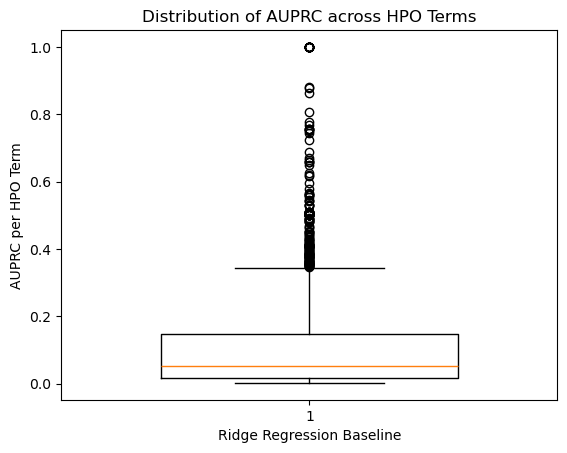

In [20]:
# box plot with results 

plt.boxplot(valid_scores, positions=[1], widths=0.6)
plt.xlabel('Ridge Regression Baseline')
plt.ylabel('AUPRC per HPO Term')
plt.title('Distribution of AUPRC across HPO Terms')


### Integrating Mouse Orthology

In [21]:
# load mouse phenotype data
url = "https://ftp.ebi.ac.uk/pub/databases/impc/all-data-releases/release-23.0/results/phenotypeHitsPerGene.csv.gz"
print("Loading IMPC data... ")

impc_df = pd.read_csv(url, compression='gzip')

# separator '::'
impc_df['phenotype_list'] = impc_df['Phenotype Hits'].str.split('::')

# explode: turns 1 row with 3 hits into 3 rows with 1 hit each
impc_long = impc_df.explode('phenotype_list')

impc_long = impc_long.rename(columns={'phenotype_list': 'mp_term'})

# key: MGI Gene Id, feature: mp_term
mouse_data = impc_long[['MGI Gene Id', 'mp_term']].drop_duplicates()

print(f"Processed {len(mouse_data)} mouse gene-phenotype associations.")
print(mouse_data.head())

Loading IMPC data... 
Processed 43539 mouse gene-phenotype associations.
  MGI Gene Id                                           mp_term
0   MGI:99403           abnormal retina blood vessel morphology
0   MGI:99403  increased circulating alkaline phosphatase level
0   MGI:99403       increased fasting circulating glucose level
0   MGI:99403                               convulsive seizures
0   MGI:99403               decreased circulating glucose level


In [22]:
from pybiomart import Server


server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['mmusculus_gene_ensembl']

print("Fetching Orthology map...")

# MGI ID <-> Mouse Ensembl ID
mgi_map = dataset.query(attributes=['mgi_id', 'ensembl_gene_id'])
mgi_map.columns = ['mgi_id', 'mouse_ensembl_id']

# Mouse Ensembl ID <-> Human Ensembl ID
homolog_map = dataset.query(attributes=['ensembl_gene_id', 'hsapiens_homolog_ensembl_gene'])
homolog_map.columns = ['mouse_ensembl_id', 'human_ensembl_id']

# Merge to link MGI -> Human
ortho_map = pd.merge(mgi_map, homolog_map, on='mouse_ensembl_id')
ortho_map = ortho_map[['mgi_id', 'human_ensembl_id']].dropna()

print(f"Mapped {len(ortho_map)} MGI IDs to Human Ensembl IDs.")

Fetching Orthology map...
Mapped 24879 MGI IDs to Human Ensembl IDs.


Create binary vector

In [26]:
# mouse_data: ['MGI Gene Id', 'mp_term']
# ortho_final: ['mgi_id', 'human_ensembl_id']
merged_mouse = ortho_map.merge(
    mouse_data, 
    left_on='mgi_id', 
    right_on='MGI Gene Id', 
    how='inner'
)

# Binary Mouse Feature Matrix
# Rows = Human Ensembl IDs, Cols = Mouse Phenotype Terms
X_mouse_feats = pd.crosstab(merged_mouse['human_ensembl_id'], merged_mouse['mp_term'])
X_mouse_feats = (X_mouse_feats > 0).astype(int)

print(f"Mouse Feature Matrix created: {X_mouse_feats.shape}")


# reindex(..., fill_value=0) to ensure genes with no mouse data get 0s
X_mouse_aligned = X_mouse_feats.reindex(X_aligned.index, fill_value=0)

# concatenate: [Human Omics Features | Mouse Phenotype Features]
X_augmented = pd.concat([X_aligned, X_mouse_aligned], axis=1)

print(f"Original Features: {X_aligned.shape[1]}")
print(f"Augmented Features: {X_augmented.shape[1]}")

# ridge regression
print("Starting Augmented Benchmark...")
aug_results = predict_hpo_terms_base(Ridge(alpha=1.0),X_augmented, Y_aligned, train_file, val_file,test_file)
aug_scores = [s for s in aug_results.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(aug_scores):.4f}")

Mouse Feature Matrix created: (7592, 1016)
Original Features: 256
Augmented Features: 1272
Starting Augmented Benchmark...
Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.0784


Low mean AUPRC -> ~1000 more features than before

Possible Solution: Compress Mouse Data with PCA

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# compress mouse features using PCA
pca = PCA(n_components=50)


X_mouse_pca = pca.fit_transform(X_mouse_feats)


X_mouse_pca_df = pd.DataFrame(
    X_mouse_pca, 
    index=X_mouse_feats.index,
    columns=[f"Mouse_PC_{i}" for i in range(50)]
)

# align and concatenate
X_mouse_pca_aligned = X_mouse_pca_df.reindex(X_aligned.index, fill_value=0)


X_augmented_smart = pd.concat([X_aligned, X_mouse_pca_aligned], axis=1)

print(f"New Augmented Shape: {X_augmented_smart.shape}")



print("Starting Augmented Benchmark...")
aug_results_smart = predict_hpo_terms_base(Ridge(alpha=1.0),X_augmented_smart, Y_aligned, train_file, val_file,test_file)
aug_scores_smart = [s for s in aug_results_smart.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(aug_scores_smart):.4f}")

New Augmented Shape: (5079, 306)
Starting Augmented Benchmark...
Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.1061


Including Borzoi embedding

In [28]:
X_borzoi = pd.read_csv("results/borzoi_embeddings_can.csv", index_col=0)
print(f"Loaded DNA Embeddings: {X_borzoi.shape}")

# 2. Alignment & Fusion
# We need genes that exist in BOTH datasets AND have HPO labels
common_genes = X_aligned.index.intersection(X_borzoi.index).intersection(Y_aligned.index)

print(f"Genes with both Omics + DNA data: {len(common_genes)}")

if len(common_genes) < 50:
    print("⚠️ WARNING: Too few genes to run reliable Cross-Validation!")
    print("Recommendation: Run the Borzoi script for at least 500 genes.")

# Align both matrices
X_omics_sub = X_aligned.loc[common_genes]
X_borzoi_sub = X_borzoi.loc[common_genes]
Y_sub = Y_aligned.loc[common_genes]

# FUSION: Concatenate columns
# [ Omics Features (256) | DNA Features (1536) ]
X_fused = pd.concat([X_omics_sub, X_borzoi_sub], axis=1)

print(f"Fused Model Input Shape: {X_fused.shape}")

Loaded DNA Embeddings: (4381, 1536)
Genes with both Omics + DNA data: 4381
Fused Model Input Shape: (4381, 1792)


In [29]:
borzoi_results = predict_hpo_terms_base(Ridge(alpha=1.0),X_fused, Y_sub, train_file, val_file,test_file)
borzoi_scores = [s for s in borzoi_results.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(borzoi_scores):.4f}")

Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 3489, Val: 451, Test: 441
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.0794
